# Multi-scale analysis
## SFtools-bigdata hands-on workshop
Jean-François Robitaille ([jean-francois.robitaille@univ-grenoble-alpes.fr](mailto:jean-francois.robitaille@univ-grenoble-alpes.fr))

Many thanks to Erik Rosolowsky for his help on *TurbuStat* functions.

This notebook presents a non-exhaustive demonstration of some python tools available to the astrophysical community to perform multi-scale and related analysis.

The demonstrations are based on mainly two packages:

 - TurbuStat - [https://github.com/Astroua/TurbuStat](https://github.com/Astroua/TurbuStat)
 - Pywavan - [https://github.com/jfrob27/pywavan](https://github.com/jfrob27/pywavan)

*TurbuStat* aimes at facilitating comparisons between spectral line data cubes. Included in this package are several techniques described in the literature which aim to describe some property of a data cube. It also includes an impressive collection of statistical analysis techniques, such as the **PDF**, the **power spectrum**, the **∆-variance**, the **dendrogram**, etc.

*Pywavan* has been developed by me and it revolves mainly around one function which is dedicated to the wavelet power spectrum analysis of a map and its **Multi-scale non-Gaussian Segmentation (MnGSeg)**. It also contains functions to perform the **classical Fourier power spectrum analysis**, generate **fractal simulations** and do basic data manipulation, such as **cutting fits maps**, **beam convolution**.

## Why multi-scale analysis techniques?

The structure formation in the interstellar medium is largely dominated by mutli-scale processes such as turbulence through its energy cascade and gravity, which is responsible for the formation of the densest structures.

Measuring the scaling behaviour of a cloud and decomposing its building blocks using several statistical techniques can help us to understand the physical mecanisms at the origin of cloud structure formation and ultimately the formation of stars.

### Dependencies

Plots and matrices

In [ ]:
!pip install matplotlib numpy

Dowload and manage fits data

In [ ]:
!pip install aplpy astropy

*Turbustat* package and dependencies

In [ ]:
!pip install turbustat astrodendro sklearn statsmodels radio_beam

*Pywavan* package

In [ ]:
!pip install git+https://github.com/jfrob27/pywavan.git

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Open data

In [5]:
from astropy.io import fits
import aplpy

Herschel Gould Belt Survey of Polaris 250 $\mu$m from [archive](http://www.herschel.fr/cea/gouldbelt/en/Phocea/Vie_des_labos/Ast/ast_visu.php?id_ast=66).

In [6]:
#HDU = fits.open('/Users/robitaij/postdoc/colloque/notebooks/polaris-250_cutB.fits')
HDU = fits.open('https://ipag.osug.fr/~robitaij/polaris-250_cutB.fits')
im = HDU[0].data
header = HDU[0].header

INFO: Auto-setting vmin to -1.422e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.904e+01 [aplpy.core]


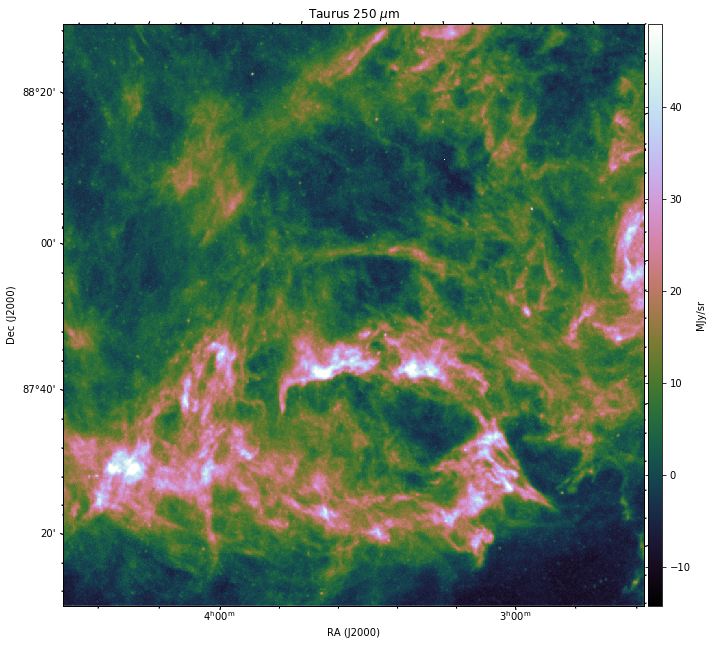

In [7]:
fig_all = plt.figure(1, figsize=(10,10))

fig = aplpy.FITSFigure(fits.PrimaryHDU(im,header=header),figure=fig_all)
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(header['BUNIT'])
fig.set_title("Taurus 250 $\mu$m")
plt.tight_layout()

# Power spectrum

A power spectrum measure the amount of power (squared amplitude of spatial fluctuations) as a function of spatial frequencies. The most common way to estimate the power spectrum is to average the squared amplitude as a function of scales over the azimuthal directions in the Fourier space.

Fourier transform of an image:
$$\hat{f}(\mathbf{k}) = \int^{\infty}_{-\infty} f(\mathbf{x}) e^{-2\pi i\mathbf{x} \cdot \mathbf{k}}d\mathbf{k}$$

Fourier power spectrum estimation:
$$P(k) = \langle |\hat{f}(\mathbf{k})|^2 \rangle_{\theta} \propto k^{-\beta}$$

## Fractional Brownian motion (fBm)

An fBm simulation is a simple way to generate random Gaussian fluctuations as a function of scales. These mock objects mimic ''part'' of the fractal behavior of interstellar medium and can be used to excute simple tests on statistical tools (as the power spectrum).

They are generated by calculating the inverse Fourier transform of random complex-number noise in the Fourier space multiplied by a power law"

In [8]:
from pywavan import fbm2d
from turbustat.simulator import make_extended

Text(0.5, 1.0, 'Turbustat')

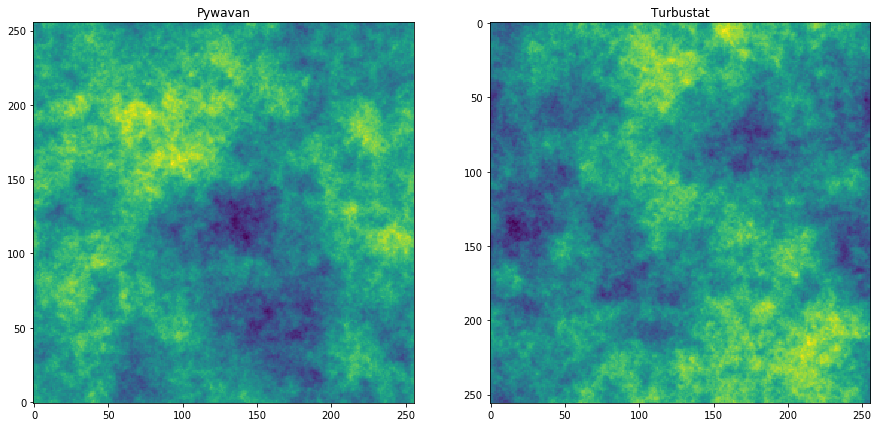

In [9]:
beta = 2.7

#Pywavan
fbm = fbm2d(-beta,256,256)

#Turbustat
fbmturbu = make_extended(256, powerlaw=beta)

figure(figsize=(15,10))
subplot(1,2,1)
imshow(fbm, origin='lower')
title('Pywavan')
subplot(1,2,2)
imshow(fbmturbu)
title('Turbustat')

Since fBms are built from a set of random-phase sinusoidal functions it has the useful property of having periodic boundaries.

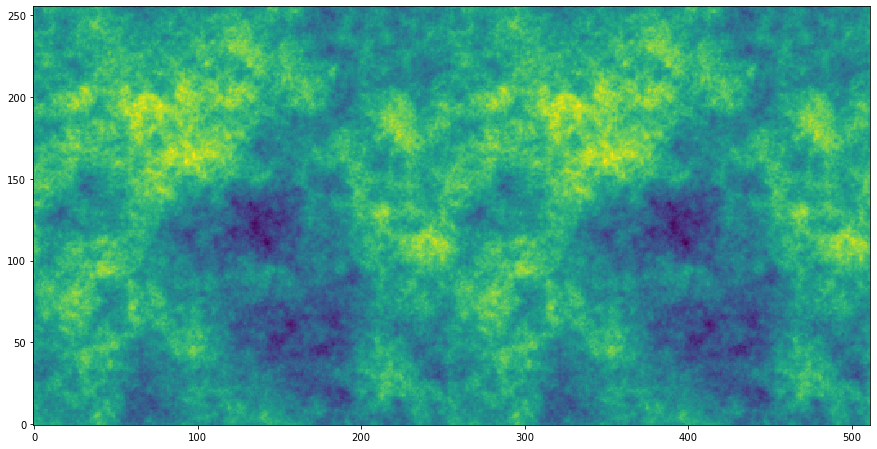

In [10]:
Lfbm = np.zeros([256,512])
Lfbm[:,:256] = fbm
Lfbm[:,256:] = fbm

figure(figsize=(15,10))
imshow(Lfbm, origin='lower')

## Fourier Power Spectrum analysis

In [11]:
from pywavan import powspec

In [12]:
tab_k, spec_k = powspec(fbm, reso = 1)
tab_k, spec_kturbu = powspec(fbmturbu, reso = 1)

#Pywavan fBm Power spectrum fit
A = np.polyfit(np.log(tab_k[1:]), np.log(spec_k[1:]),deg=1)
fit = np.exp(A[1])*tab_k**A[0]
print('Pywavan fBm Power fit')
print('A, Beta = ', np.exp(A[1]), A[0])

#Turbustat fBm Power spectrum fit
A = np.polyfit(np.log(tab_k[1:]), np.log(spec_kturbu[1:]),deg=1)
fit_turbu = np.exp(A[1])*tab_k**A[0]
print('Turbustat fBm Power fit')
print('A, Beta = ', np.exp(A[1]), A[0])

Pywavan fBm Power fit
A, Beta =  0.0018363187863968905 -2.6880363279955644
Turbustat fBm Power fit
A, Beta =  0.0029990529648029284 -2.6880363279955635


Text(0.5, 1.0, 'Turbustat')

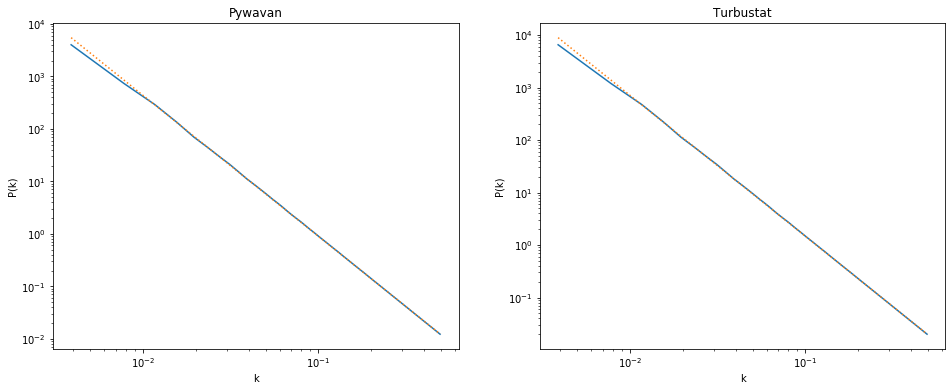

In [13]:
figure(figsize=(16,6))
subplot(1,2,1)
plot(tab_k, spec_k)
plot(tab_k, fit, linestyle = ':')
xscale('log')
yscale('log')
xlabel('k')
ylabel('P(k)')
title('Pywavan')

subplot(1,2,2)
plot(tab_k, spec_kturbu)
plot(tab_k, fit_turbu, linestyle = ':')
xscale('log')
yscale('log')
xlabel('k')
ylabel('P(k)')
title('Turbustat')

In [16]:
from turbustat.statistics import PowerSpectrum
import astropy.units as u

/Users/robitaij/anaconda2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/robitaij/anaconda2/lib/python3.7/site-packages/turbustat/statistics/base_pspec2.py:421: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "
/Users/robitaij/anaconda2/lib/python3.7/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.243e+05
Date:                Thu, 19 Nov 2020   Prob (F-statistic):          1.44e-293
Time:                        19:15:20   Log-Likelihood:                 629.43
No. Observations:                 181   AIC:                            -1255.
Df Residuals:                     179   BIC:                            -1248.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0795      0.003    740.660      0.0

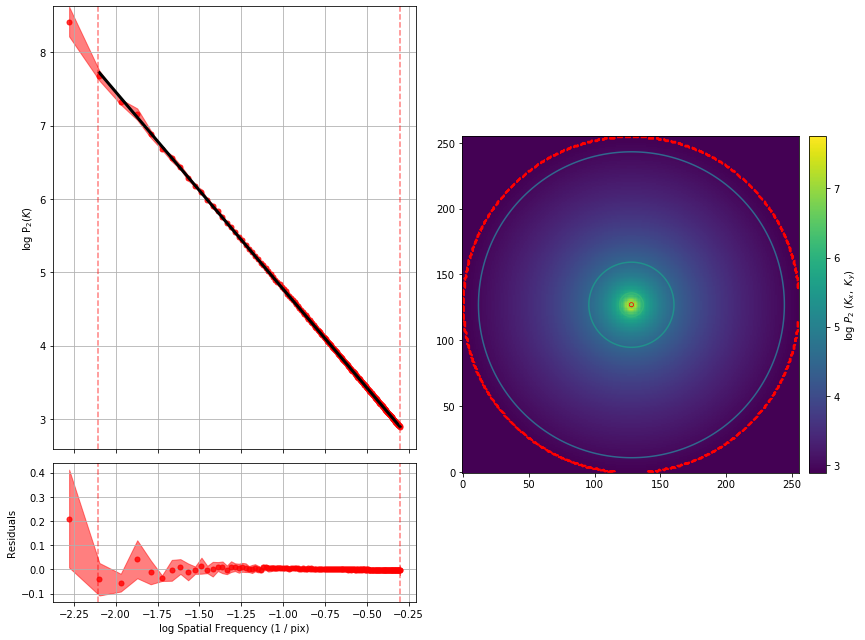

In [17]:
figure(figsize=(12,9))
pspec = PowerSpectrum(fits.PrimaryHDU(fbm))
pspec.run(verbose=True, xunit=u.pix**-1, use_wavenumber=False)

## Fourier power spectrum analysis on Polaris

The scaling properties of the Polaris flare region has been analysed several times ([Miville-Deschênes et al. 2010](https://ui.adsabs.harvard.edu/abs/2010A%26A...518L.104M/abstract), [Robitaille et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...628A..33R/abstract), [Allys et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...629A.115A/abstract)). Polaris is particularly interesting because it is a young stellar region and it has an apparent scale-free property.

In [18]:
from pywavan import apodize, padding, gauss_beam

In [19]:
#Resolution in arcmin
reso = header['CDELT2'] * 60.

#Apodization
imzm = im - np.mean(im)
tapper = apodize(im.shape[0],im.shape[1],0.98)
imt = imzm *tapper
nsize = 1024
imr = padding(imt,nsize,nsize)

#Fourier Powre Spectrum
tab_k_im, spec_k_im = powspec(imr, reso = reso)

In [20]:
#Noise evaluation
noise = np.mean(spec_k_im[(tab_k_im > 3.) & (tab_k_im < 5.)])

#Beam Power spectrum
FWHM = 18.2 / (60.*reso)  #Beam size at 250 micron
header['BMAJ'] = 18.2 / 3600.
header['BMIN'] = 18.2 / 3600.
header['BPA'] = 0.
beam = gauss_beam(FWHM,1024,1024,FWHM=True)
tab_k_im, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation

In [21]:
#Power spectrum fit
limites = np.where((tab_k_im >= tab_k_im[1]) & (tab_k_im < 1.0))

A = np.polyfit(np.log(tab_k_im[limites]), np.log((spec_k_im[limites]-noise)/spec_beamn[limites]),deg=1)
fit_im = np.exp(A[1])*tab_k_im**A[0]
print('Pywavan fBm Power fit')
print('A, Gamma = ', np.exp(A[1]), A[0])

Pywavan fBm Power fit
A, Gamma =  25.77394743019556 -2.7751900733131007


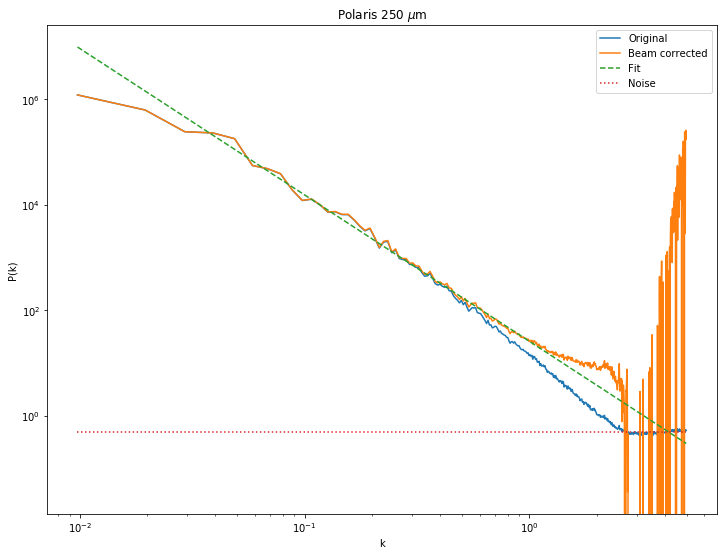

In [22]:
figure(figsize=(12,9))
plot(tab_k_im, spec_k_im, label='Original')
plot(tab_k_im, (spec_k_im-noise)/spec_beamn, label='Beam corrected')
plot(tab_k_im, fit_im, linestyle='--', label='Fit')
plot([tab_k_im[0],tab_k_im[-1]], [noise,noise], linestyle=':', label='Noise')
xscale('log')
yscale('log')
xlabel('k')
ylabel('P(k)')
title('Polaris 250 $\mu$m')
legend()

/Users/robitaij/anaconda2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     6561.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):          6.11e-104
Time:                        19:15:28   Log-Likelihood:                 148.14
No. Observations:                 118   AIC:                            -292.3
Df Residuals:                     116   BIC:                            -286.7
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5153      0.044    103.673      0.0

/Users/robitaij/anaconda2/lib/python3.7/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


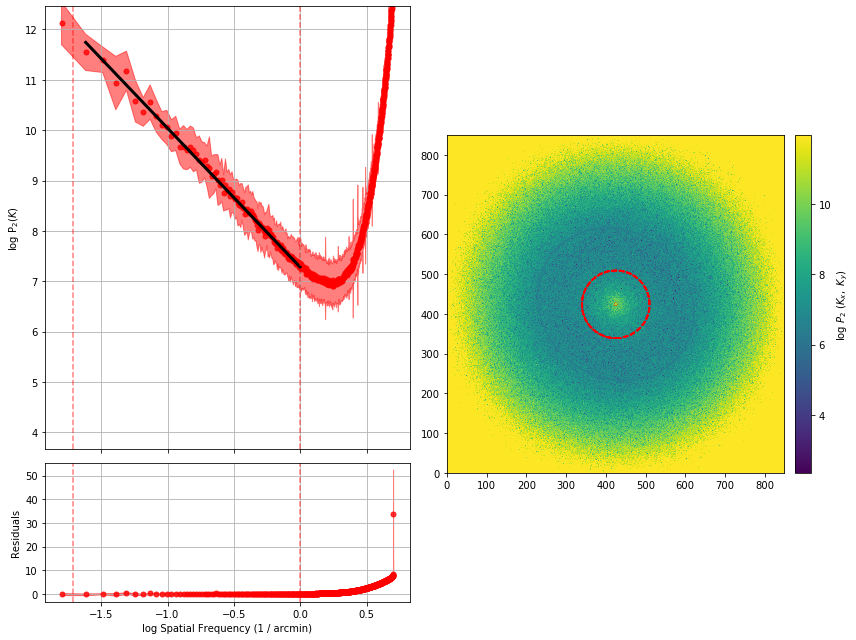

In [23]:
figure(figsize=(12,9))
pspec = PowerSpectrum(im,header)
#pspec.run(verbose=True, use_wavenumber=False, fit_2D_kwargs={'fix_ellip_params':True})
pspec.run(verbose=True, use_wavenumber=False, xunit=u.arcmin**-1, low_cut=tab_k_im[1] / u.arcmin, high_cut=1.0 / u.arcmin,
          apodize_kernel='tukey', beam_correct=True)

## Probability density distribution (PDF)

Properties of the PDF, when related to an analytical form, have been found to correlate with changes in the turbulent properties (e.g., [Kowal et al. 2007](https://ui.adsabs.harvard.edu/abs/2007ApJ...658..423K/abstract), [Federrath et al. 2010](https://ui.adsabs.harvard.edu/abs/2010A%26A...512A..81F/abstract)), gravity (e.g., [Burkhart et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...808...48B/abstract), [Burkhart et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...834L...1B/abstract)) and star formation activity ([Schneider et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...766L..17S/abstract)).

In [24]:
from turbustat.statistics import PDF

### fBm PDF

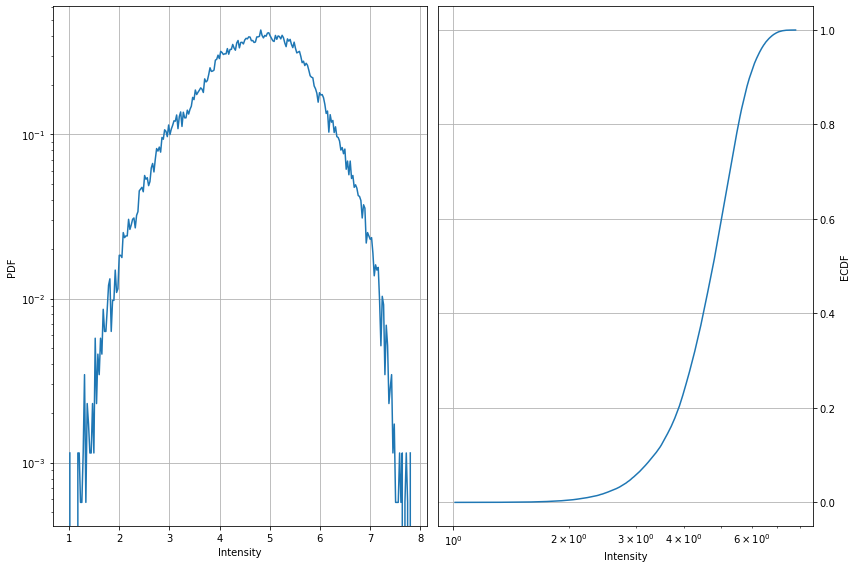

In [25]:
figure(figsize = (12,8))
pdf_fbm = PDF(fbm-np.min(fbm)+1., bins=None)  
pdf_fbm.run(verbose=True, do_fit=False)

### Polaris PDF

Optimization terminated successfully.
         Current function value: -0.556826
         Iterations: 16
         Function evaluations: 33
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:             4.0231e+05
Model:                     Likelihood   AIC:                        -8.046e+05
Method:            Maximum Likelihood   BIC:                        -8.046e+05
Date:                Thu, 19 Nov 2020                                         
Time:                        19:15:33                                         
No. Observations:              722498                                         
Df Residuals:                  722496                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

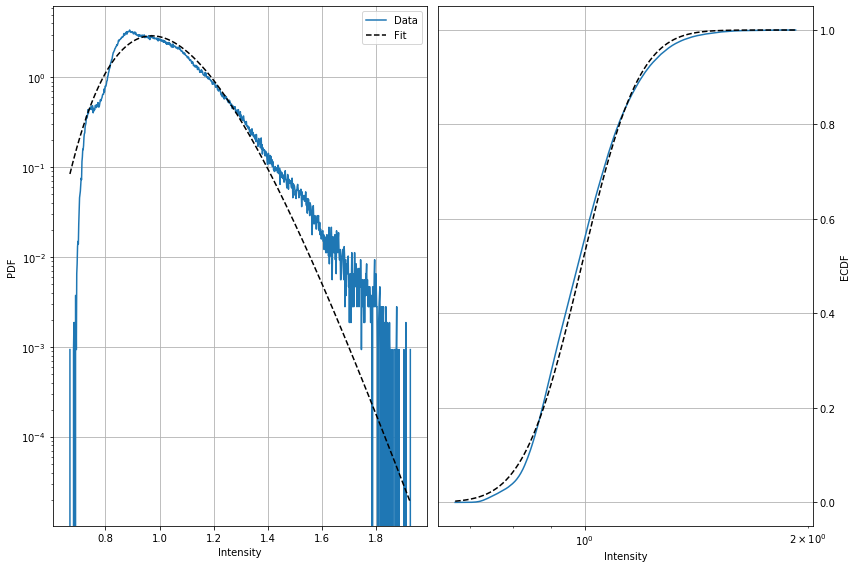

In [26]:
im_mod = im-np.min(im)+1.
im_mod = im_mod / np.mean(im_mod)
# Truncate data to be < 5
im_mod = im_mod[(im_mod < 5) & (im_mod > 0.25)]

figure(figsize = (12,8))
pdf_im = PDF(im_mod, bins=None)#, normalization_type='normalize_by_mean')  
pdf_im.run(verbose=True, do_fit=True)

### Exponentiated fBm

The exponential of a Gaussian distribution is a lognormal distribution.

$$\rho_{\rm efbm}(\mathbf{x}) = \exp [\sigma_{\rho}f(\mathbf{x})]$$

The latter is often observed in star forming regions. According to [Padoan et al. (1997)](https://ui.adsabs.harvard.edu/abs/1997ApJ...474..730P/abstract), $\sigma_{\rho}$ can be related to the Mach number, $\mathcal{M}$, as

$$\sigma_{\rho} = (\ln[1+0.5^2\mathcal{M}^2])^{0.5}$$

In [27]:
mach = 0.8
sigrho = np.log(1+0.5**2.*mach**2.)**0.5

efbm = np.exp(sigrho*fbm)

Optimization terminated successfully.
         Current function value: 0.465084
         Iterations: 19
         Function evaluations: 39
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:                -30480.
Model:                     Likelihood   AIC:                         6.097e+04
Method:            Maximum Likelihood   BIC:                         6.099e+04
Date:                Thu, 19 Nov 2020                                         
Time:                        19:15:34                                         
No. Observations:               65536                                         
Df Residuals:                   65534                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

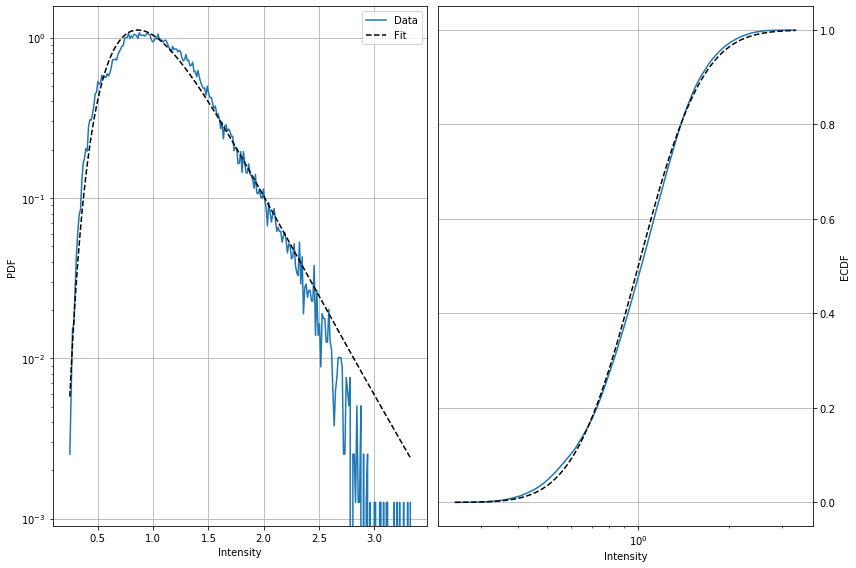

In [28]:
figure(figsize = (12,8))
pdf_efbm = PDF(efbm, bins=None)  
pdf_efbm.run(verbose=True, do_fit=True)

In [29]:
tab_k, spec_ke = powspec(efbm, reso = 1)

#Pywavan fBm Power spectrum fit
A = np.polyfit(np.log(tab_k[1:]), np.log(spec_ke[1:]),deg=1)
efit = np.exp(A[1])*tab_k**A[0]
print('efBm Power fit')
print('A, Beta = ', np.exp(A[1]), A[0])

efBm Power fit
A, Beta =  0.0003711550522885871 -2.668029995125675


Text(0.5, 1.0, 'PDF')

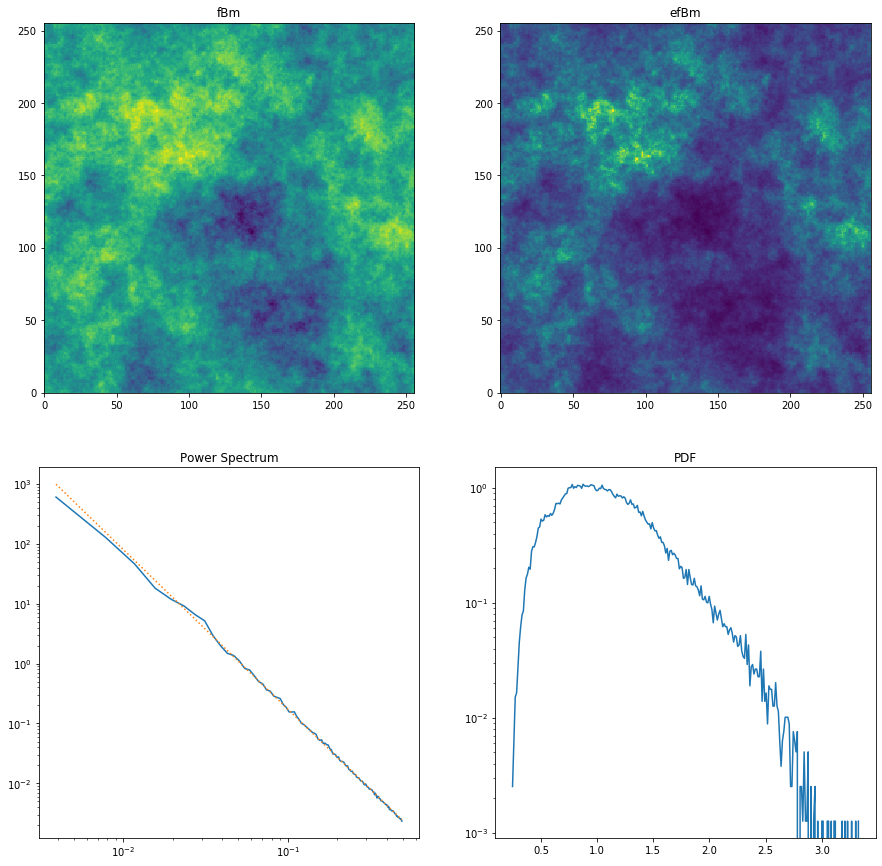

In [30]:
figure(figsize=(15,15))
subplot(2,2,1)
imshow(fbm, origin='lower')
title('fBm')
###
subplot(2,2,2)
imshow(efbm, origin='lower')
title('efBm')
###
subplot(2,2,3)
plot(tab_k, spec_ke)
plot(tab_k, efit, linestyle = ':')
xscale('log')
yscale('log')
title('Power Spectrum')
###
subplot(2,2,4)
plot(pdf_efbm.bins, pdf_efbm.pdf)
yscale('log')
title('PDF')

# Wavelet Power Spectrum

Similarly to the $\Delta$-variance, a wavelet power spectrum measures the scaling behaviour of a signal while taking advantage of wavelet transforms over the Fourier transform.

- The Fourier transform transform gives the complete frequency content of a signal.
- Wavelet transforms decompose an image as a function of spatial frequencies, while keeping the spatial distribution of the signal fluctuation.

*Pywavan* ([Robitaille et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...628A..33R/abstract)) uses the continuous Morlet wavelet:

$$\Psi(\mathbf{x}) = e^{i\mathbf{k}_0\mathbf{x}}e^{-|\mathbf{x}|^2/2}$$

and its rotated version introduced by [Kirby et al. (2005)](https://ui.adsabs.harvard.edu/abs/2005CG.....31..846K/abstract).

Text(0.5, 0.92, 'Morlet wavelet (real part)')

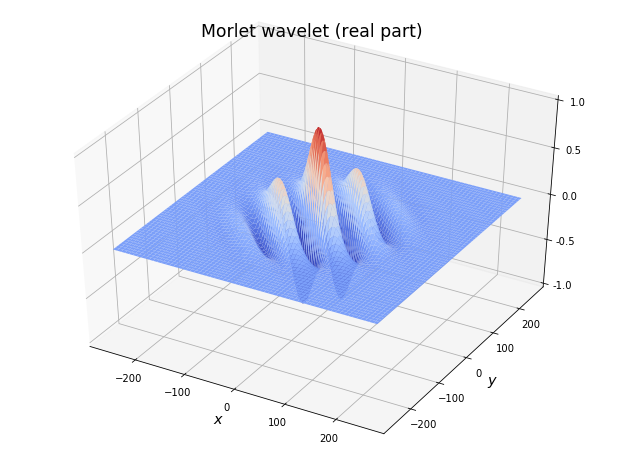

In [31]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

na = 512
nb = 512

ko = 5.336
delta = (2.*np.sqrt(-2.*np.log(.75)))/ko
N = int(np.pi/delta)	#Number of orientation for the Morlet wavelet

#Morlet wavelet in X space (Real part)
#----------------------------------------------

#t = 0.
t = np.pi/4.
cmap = cm.coolwarm

a=60

x = np.arange(-na/2, na/2, 1.)
y = np.arange(-nb/2, nb/2, 1.)
x, y = np.meshgrid(x, y)

Mxr = np.cos( (ko/a)*( x*np.cos(t) + y*np.sin(t) ) ) * np.exp( -0.5*(x**2+y**2)/a**2)

fig = plt.figure(figsize=(24,18))
ax = fig.add_subplot(2, 2, 1, projection='3d')

norm = colors.Normalize(vmin=-0.25,vmax=1.)

ax.plot_surface(x, y, Mxr, cmap=cmap,
                 linewidth=1.0, antialiased=True, rstride=8, cstride=8, norm=norm)
#ax.plot_wireframe(x, y, Mxr, rcount=70, ccount=70, antialiased=True, linewidth=0.7)

ax.set_zlim(-1.0, 1.0)
ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.view_init(elev=40)
ax.set_xlabel('$x$', size='x-large')
ax.set_ylabel('$y$', size='x-large')

ax.set_title('Morlet wavelet (real part)',size='xx-large')

### Wavelet tranforms of Polaris

In [32]:
from pywavan import fan_trans

In [33]:
%%time
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=0, apodize= 0.98
                                    , arrdim = np.array([nsize,nsize]), angular=False)

1024 1024
CPU times: user 18.2 s, sys: 2.18 s, total: 20.4 s
Wall time: 22.5 s


*fan_trans* outputs

S11a
$$P^W(l,\mathbf{x})=\frac{\delta \theta}{N_{\theta}} \sum_{j=0}^{N_{\theta}-1}  |\tilde{f}(l,\mathbf{x},\theta_j)|^2$$

S1a

$$P^W(l)=\frac{1}{N_{\mathbf{x}}} \sum_{\mathbf{x}} P^W(l,\mathbf{x})$$

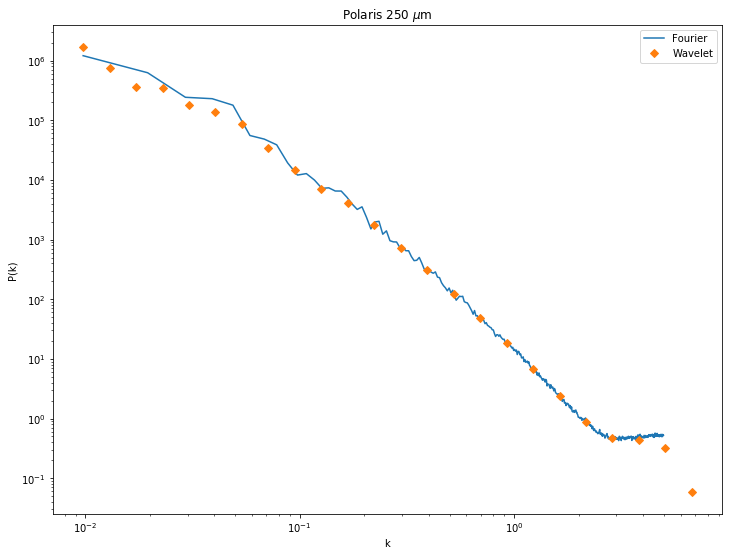

In [34]:
figure(figsize=(12,9))
plot(tab_k_im, spec_k_im, label='Fourier')
plot(wav_k, S1a, 'D', label='Wavelet')
#plot(tab_k_im, (spec_k_im-noise)/spec_beamn, label='Beam corrected')
#plot(tab_k_im, fit_im, linestyle='--', label='Fit')
#plot([tab_k_im[0],tab_k_im[-1]], [noise,noise], linestyle=':', label='Noise')
xscale('log')
yscale('log')
xlabel('k')
ylabel('P(k)')
title('Polaris 250 $\mu$m')
legend()

INFO: Auto-setting vmin to -5.025e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.113e+00 [aplpy.core]
INFO: Auto-setting vmin to -6.872e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.989e+03 [aplpy.core]


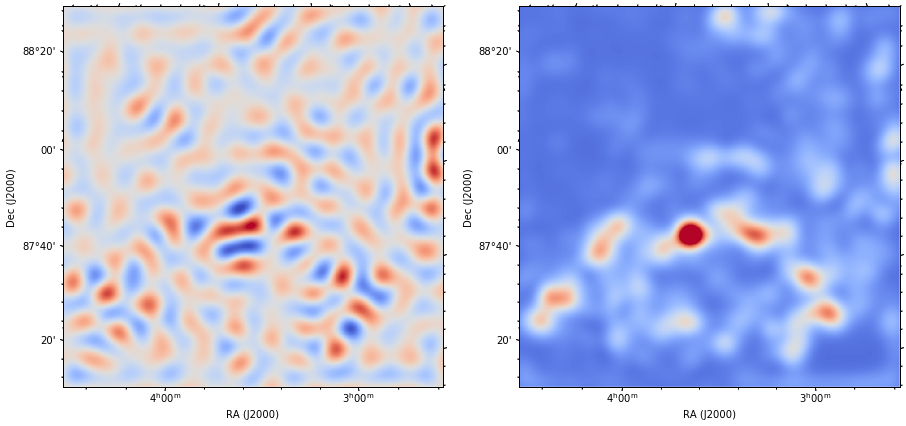

In [35]:
fig_all = plt.figure(1, figsize=(15,9))
aplpy.FITSFigure(fits.PrimaryHDU(wt[9,:,:].real,header=header)
                       ,figure=fig_all, subplot=(1,2,1)).show_colorscale(cmap='coolwarm')
###
aplpy.FITSFigure(fits.PrimaryHDU(S11a[12,:,:].real,header=header)
                       ,figure=fig_all, subplot=(1,2,2)).show_colorscale(cmap='coolwarm')

INFO: Auto-setting vmin to -9.638e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.198e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.997e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.038e+00 [aplpy.core]


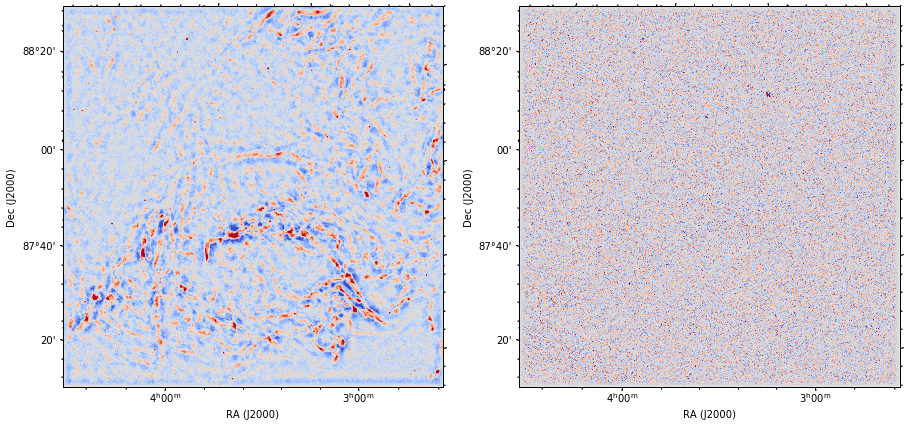

In [36]:
fig_all = plt.figure(1, figsize=(15,9))
aplpy.FITSFigure(fits.PrimaryHDU(np.sum(wt[12:,:,:].real,axis=(0)),header=header)
                       ,figure=fig_all, subplot=(1,2,1)).show_colorscale(cmap='coolwarm')
###
aplpy.FITSFigure(fits.PrimaryHDU(np.sum(wt[-4:-1,:,:].real,axis=0),header=header)
                       ,figure=fig_all, subplot=(1,2,2)).show_colorscale(cmap='coolwarm')

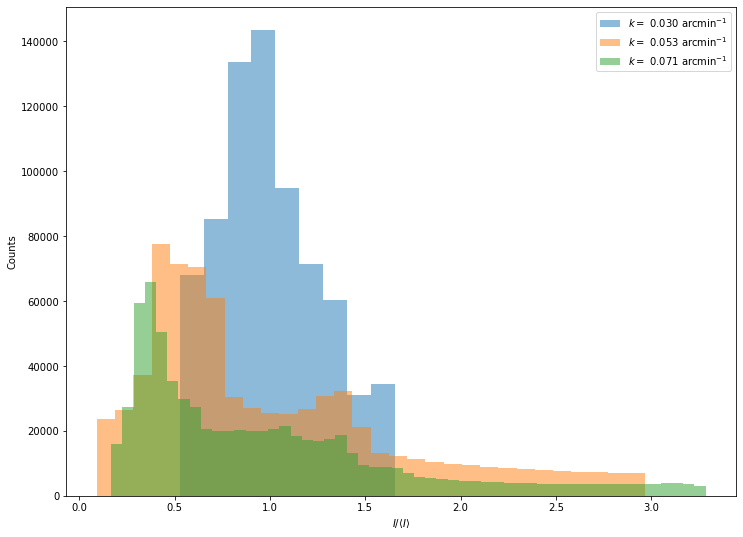

In [37]:
scls = [4,6,7]

plt.figure(figsize=(12,9))
for scl in scls:
    nbins = np.int(nsize**2. * (wav_k[scl]*reso)**2.)
    intermit = (S11a[scl,:,:])/np.mean(S11a[scl,:,:])
    histo, edges = np.histogram(intermit,bins=nbins)
    plt.bar(edges[:-1], histo, width=np.diff(edges), align="edge",alpha=0.5
            , label= r'$k=$ '+np.str(wav_k[scl])[:5]+r' arcmin$^{-1}$')
plt.xlabel(r'$I/\langle I \rangle$')
plt.ylabel(r"Counts")

plt.legend()

## Multiscale non-Gaussian Segmentation (MnGSeg)

This iterative algorithm was initially developed as a method to determine the optimal denoising threshold among wavelet coefficients. In many cases, denoising consists in deleting the wavelet coefficients of a noisy signal whose modulus is below a threshold, usually found at small scales, and reconstructing the denoised signal from the remaining coefficients [Azzalini et al. 2005](https://www.sciencedirect.com/science/article/pii/S1063520304000752). In our case, the algorithm is applied at every spatial scales and as a function of the azimuthal direction.

The algorithm is defined as follows, let $\Phi$ be the threshold splitting the non-Gaussian terms from the Gaussian terms in the wavelet coefficient distribution and $\mathbb{L}_{\Phi}$ be the function indicator. The threshold $\Phi$ is first estimated according to the variance,


$$\sigma_{l,\theta}^2(\Phi)=\frac{1}{N_{l,\theta}(\Phi)}\sum_{\mathbf{x}} \mathbb{L}_{\Phi}( |\tilde{f}_{l,\theta}(\mathbf{x})|) |\tilde{f}_{l,\theta}(\mathbf{x})|^2,$$

where

$$\mathbb{L}_{\Phi}(|\tilde{f}_{l,\theta}(\mathbf{x})|)=\left\{
        									          \begin{array}{ll}
  									          1 & \qquad \mathrm{if} \quad |\tilde{f}_{l,\theta}(\mathbf{x})| < \Phi \\
 									          0 & \qquad \mathrm{else}. \\
 									         \end{array}
  									         \right.$$

and


$$N_{l,\theta}(\Phi)=\sum_{\mathbf{x}} \mathbb{L}_{\Phi}( |\tilde{f}_{l,\theta}(\mathbf{x})|).$$

The iterative calculation then converges to an optimal value of the threshold $\Phi$ which allows one to separate outliers from randomly distributed wavelet coefficients. The sequence is defined by:


$$\left\{
        	 \begin{array}{l}
  	   \Phi_{0}(l,\theta)=\infty \\
 	   \Phi_{n+1}(l,\theta)=q \sigma_{l,\theta}(\Phi_{n}(l,\theta)), \\
 	 \end{array}
  	 \right.$$

where $q$ is a dimensionless constant controlling how restrictive is the definition of non-Gaussianities.

In [38]:
%%time
M = wav_k.size
#q=[]
#q=[2.5]*M
q=[2.5,2.5,2.5,2.5,2.5,2.5,2.0,1.8,1.8,2.0,1.9,2.0,2.0,1.9,2.0,2.0,1.9,2.0,2.0,2.0,2.0,2.0,2.0,2.0]

wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=False, apodize= 0.98
                                    , arrdim = np.array([nsize,nsize]), angular=False)

1024 1024
CPU times: user 1min 19s, sys: 8.14 s, total: 1min 27s
Wall time: 1min 31s


INFO: Auto-setting vmin to -1.956e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.539e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.468e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.357e+01 [aplpy.core]


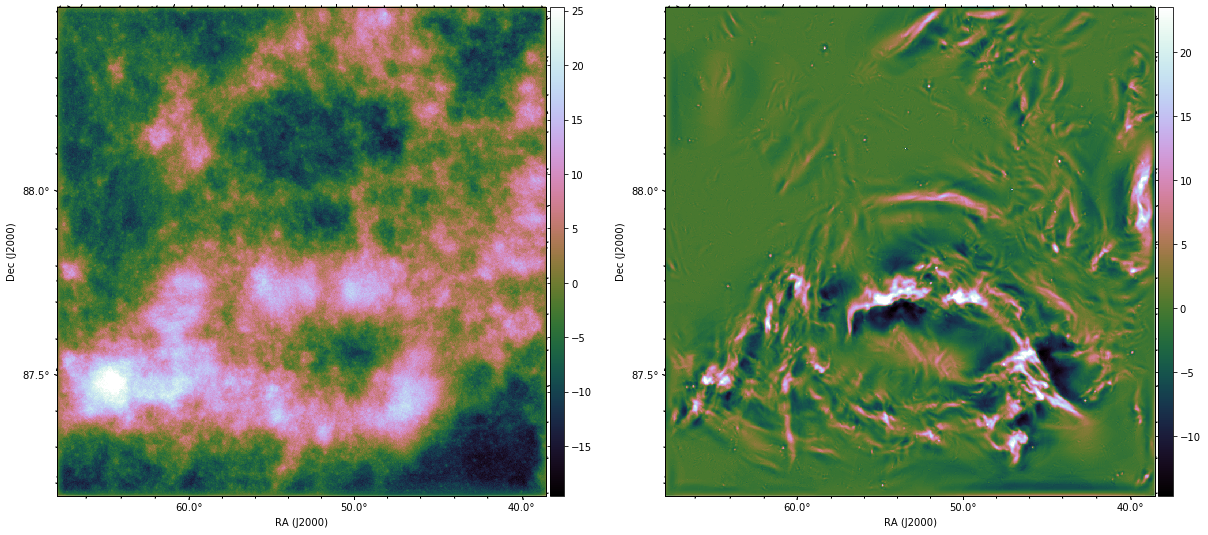

In [39]:
coherent = np.sum(wt[M:2*M,:,:],axis=0)  + np.mean(im)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)  + np.mean(im)

fig_all = plt.figure(1, figsize=(20,10))

fig = aplpy.FITSFigure(fits.PrimaryHDU(Gaussian.real,header=header), figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

fig = aplpy.FITSFigure(fits.PrimaryHDU(coherent.real,header=header), figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

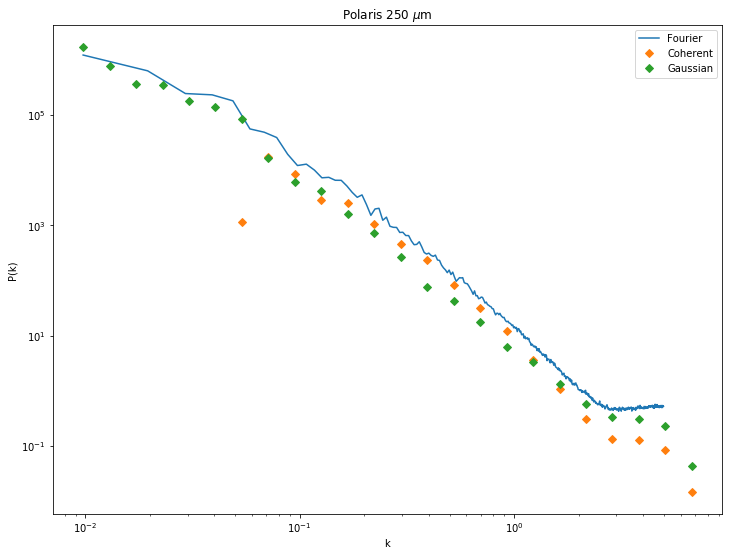

In [40]:
figure(figsize=(12,9))
plot(tab_k_im, spec_k_im, label='Fourier')
plot(wav_k, S1a[1,:], 'D', label='Coherent')
plot(wav_k, S1a[2,:], 'D', label='Gaussian')
#plot(tab_k_im, (spec_k_im-noise)/spec_beamn, label='Fourier')
#plot(wav_k, (S1a[1,:]-noise)/S1aBn, 'D', label='Coherent')
#plot(wav_k, (S1a[2,:]-noise)/S1aBn, 'D', label='Gaussian')
#plot(wav_k, fitG, '--', label='Gaussian fit')
xscale('log')
yscale('log')
xlabel('k')
ylabel('P(k)')
title('Polaris 250 $\mu$m')
legend()

<img src="https://ipag.osug.fr/~robitaij/aa35545-19-fig12.png" width=500 height=500 />

In [44]:
#Power spectrum fit

Ag = np.polyfit(np.log(wav_k[7:17]), np.log((S1a[2,7:17]-noise)/S1aBn[7:17]),deg=1)
fitG = np.exp(Ag[1])*wav_k**Ag[0]
print('Gaussian Power fit')
print('A, Gamma = ', np.exp(Ag[1]), Ag[0])

Gaussian Power fit
A, Gamma =  7.886154974090134 -2.9268504542267597


Beam correction for the wavelet spectrum

In [42]:
wtB, S11aB, wav_k, S1aB, qB = fan_trans(beam, reso=reso, q=0, angular=False)
del wtB, S11aB, qB

In [43]:
#Normalisation
S1aBn = S1aB/S1aB[3]
S1aBn[:3] = 1.

In [ ]:
figure(figsize=(12,9))
plot(wav_k,  S1aBn,'d', label='Fourier')
xscale('log')
yscale('log')
xlabel('k')
ylabel('P(k)')
title('Beam')

## Comparison with fBms

In [45]:
from pywavan import imsmooth

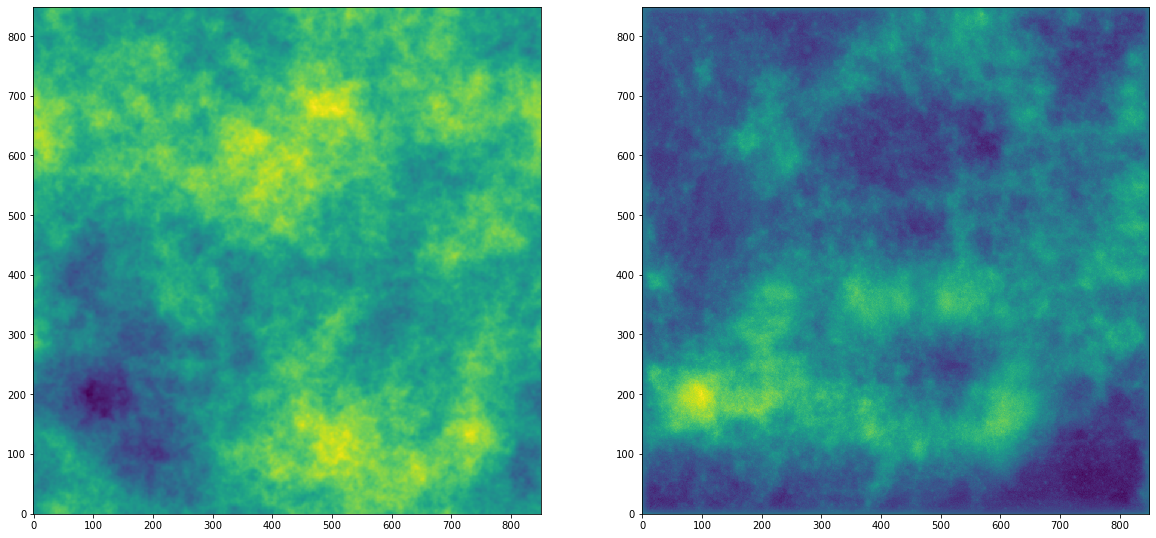

In [46]:
fbm_polaris = fbm2d(Ag[0],im.shape[1],im.shape[0])

figure(figsize=(20,10))
subplot(1,2,1)
imshow(imsmooth(fbm_polaris,FWHM),origin='lower')

subplot(1,2,2)
imshow(Gaussian.real,origin='lower')

## Multiplicative random cascade model
[Robitaille et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...641A.138R/abstract)

As noted by [Vazquez-Semadeni (1994)](https://ui.adsabs.harvard.edu/abs/1994ApJ...423..681V/abstract), hierarchical structures are naturally expected to arise in flows in which the density has a log-normal distribution. This emergence of a universal distribution can be associated with the central limit theorem, for which the sum of a large number of random variables converges to a normal distribution. If this assumption is attributed to a random sequence of $\ln\rho$, then the density $\rho$ becomes log-normally distributed. Thus, according to this description, after a finite time, density can be considered the product of a large number of independent random fluctuations $\delta$,

$$\rho(t_n)=\delta_n\delta_{n-1}\textrm{... }\delta_1\delta_0\rho(t_0)$$

We note the correspondence between the equation above and the multiplicative random cascade model that is designed to reproduce the multifractal nature of intermittency in developed turbulence ([Meneveau & Sreenivasan 1991](https://ui.adsabs.harvard.edu/abs/1991JFM...224..429M/abstract); Frisch 1995). In this model, the rate of turbulent energy dissipation $\varepsilon$ is considered first as a nonrandom positive quantity for a cubic volume of side $\ell_0$. This volume is then subdivided into eight equal cubes of side $\ell_1 = \ell_0/2$. For every subdivisions, the dissipation $\varepsilon$ is multiplied by a series of independent random variables $W_n$ that are distributed identically. After $n$ generations, the dissipation value of a cube of side $\ell_n = \ell_02^{-n}$  becomes $\varepsilon_{\ell}=W_nW_{n-1}\textrm{... }W_1W_0\varepsilon$.

In [47]:
wtA, S11aA, wav_kA, S1aA, qA = fan_trans(fbm_polaris, reso=reso, q=0, angular=True)
del S11aA

In [48]:
mfrac = np.zeros(fbm_polaris.shape)
Ndir = wtA.shape[1]
coeff = 0.202     #Mach=1.5
mach2 = np.sqrt(2*(np.exp((coeff)**2.)-1))
print('Mach=',mach2)

for j in range(Ndir):
    casc=np.zeros(fbm_polaris.shape)   
    for i in range(np.size(wav_kA)):
        aa=np.copy(wtA[i,j,:,:].real)
        casc+=aa/np.std(aa)*coeff
    mfrac+=np.exp(casc)
    
mfrac = mfrac / Ndir

Mach= 0.2886101957429105


INFO: Auto-setting vmin to -2.401e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.156e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.494e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.456e+01 [aplpy.core]


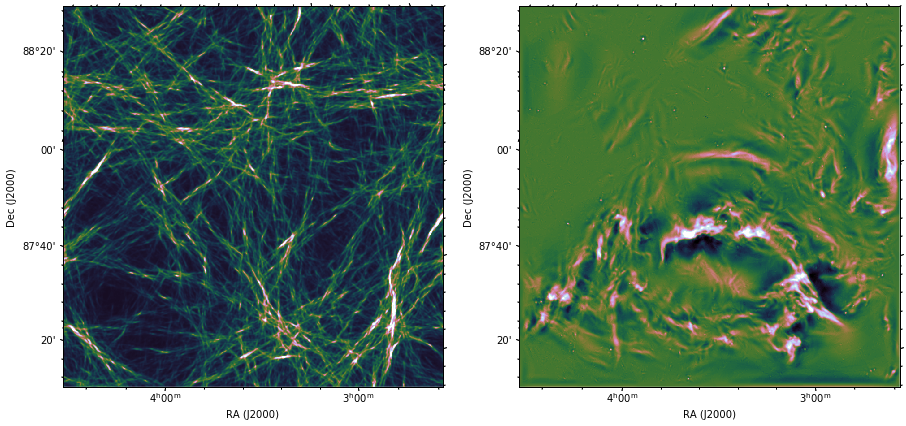

In [49]:
fig_all = plt.figure(1, figsize=(15,9))
aplpy.FITSFigure(fits.PrimaryHDU(imsmooth(mfrac,FWHM),header=header)
                       ,figure=fig_all, subplot=(1,2,1)).show_colorscale(cmap='cubehelix')
###
aplpy.FITSFigure(fits.PrimaryHDU(coherent.real,header=header)
                       ,figure=fig_all, subplot=(1,2,2)).show_colorscale(cmap='cubehelix')

A little similar... but if we look at the basic statistics.

Optimization terminated successfully.
         Current function value: 0.892119
         Iterations: 19
         Function evaluations: 39
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:            -6.4446e+05
Model:                     Likelihood   AIC:                         1.289e+06
Method:            Maximum Likelihood   BIC:                         1.289e+06
Date:                Thu, 19 Nov 2020                                         
Time:                        19:26:15                                         
No. Observations:              722387                                         
Df Residuals:                  722385                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

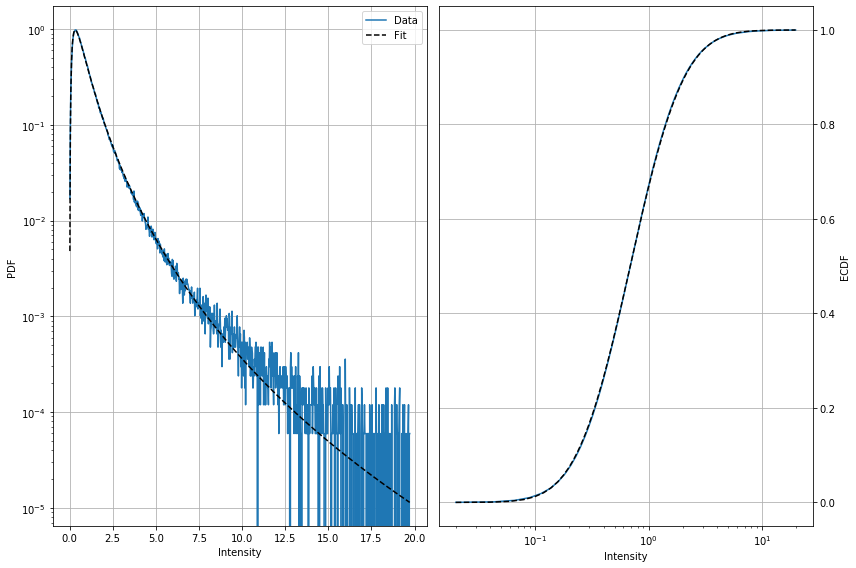

In [50]:
mfrac_mod = mfrac / np.mean(mfrac)
# Truncate data to be < 5
mfrac_mod = mfrac_mod[(mfrac_mod < 20)]

figure(figsize = (12,8))
pdf_mfrac = PDF(mfrac_mod, bins=None)  
pdf_mfrac.run(verbose=True, do_fit=True)

Text(0, 0.5, 'P(k)')

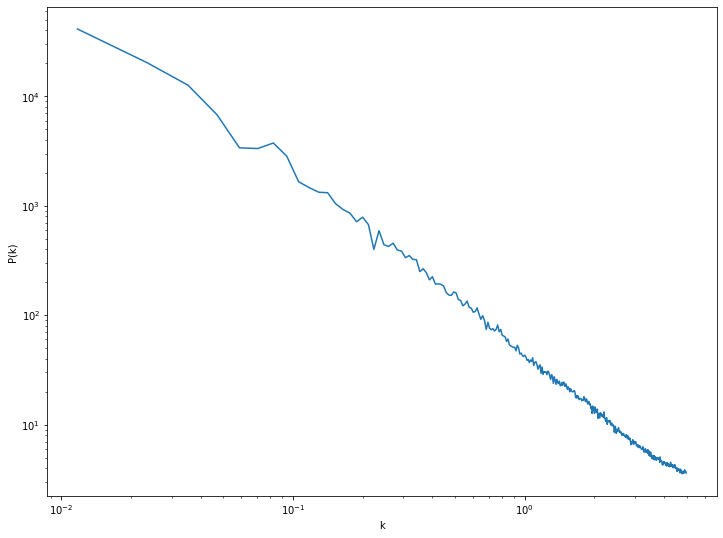

In [51]:
tab_k_mfrac, spec_k_mfrac = powspec(mfrac, reso = reso)

figure(figsize=(12,9))
plot(tab_k_mfrac, spec_k_mfrac)
xscale('log')
yscale('log')
xlabel('k')
ylabel('P(k)')